In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import librosa
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn.functional as F
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import os

sr = None specifies that librosa should use the native sampling rate of 44.1KHz to load the audio data. Next, the first 5 seconds of the given audio is extracted. 2048 samples are chosen for each window which is approximately 46ms and a hop_length of 512 samples is chosen which means the window is moved by skipping 512 samples to get the next time frame. The number of mel filters is 128 which makes the height of spectrogram image 128. fmin and fmax are the lowest and highest frequencies respectively. [https://medium.com/@hasithsura/audio-classification-d37a82d6715]

Load the .csv file we created during preprocessing step and reset its index

In [1]:




audio_impro_processed = pd.read_csv('audio_df_improvised.csv')

audio_impro_processed.reset_index(inplace=True)
audio_impro_processed.head()

,index,start_time,end_time,wav_file,emotion,val,act,dom
0,0,6.2901,8.2357,Ses01F_impro01_F000,neu,2.5,2.5,2.5
1,1,10.0100,11.3925,Ses01F_impro01_F001,neu,2.5,2.5,2.5
2,2,14.8872,18.0175,Ses01F_impro01_F002,neu,2.5,2.5,2.5
3,3,27.4600,31.4900,Ses01F_impro01_F005,neu,2.5,3.5,2.0
4,4,85.2700,88.0200,Ses01F_impro01_F012,ang,2.0,3.5,3.5


Next we create a labels.csv file from the improvised csv so that we can use fastai databunch

In [4]:
df = pd.DataFrame()
df['name'] = '/data/home/datasets/sentences/' + audio_impro_processed.wav_file
df['labels'] = audio_impro_processed.emotion

df.head()

,name,labels
0,/data/home/datasets/sentences/Ses01F_impro01_F000,neu
1,/data/home/datasets/sentences/Ses01F_impro01_F001,neu
2,/data/home/datasets/sentences/Ses01F_impro01_F002,neu
3,/data/home/datasets/sentences/Ses01F_impro01_F005,neu
4,/data/home/datasets/sentences/Ses01F_impro01_F012,ang


sr = None specifies that librosa should use the native sampling rate of 44.1KHz to load the audio data. Next, the first "med_duration" seconds of the given audio is extracted. If audio is smaller than that it is padded reflectively to make sure there is no added information. 2048 samples are chosen for each window which is approximately 46ms and a hop_length of 512 samples is chosen which means the window is moved by skipping 512 samples to get the next time frame. The number of mel filters is 128 which makes the height of spectrogram image 128. fmin and fmax are the lowest and highest frequencies respectively. [https://medium.com/@hasithsura/audio-classification-d37a82d6715].

In [2]:
def get_melspectrogram_db(file_path, med_duration ,sr=None, n_fft=2048, hop_length=256, n_mels=128, fmin=100, fmax=15000, top_db=80):
    med_duration = int(np.floor(med_duration))
    wav,sr = librosa.load(file_path,sr=sr)
    if wav.shape[0]<(med_duration*sr):
        wav=np.pad(wav,int(np.ceil(((med_duration*sr)-wav.shape[0])/2)),mode='reflect')
    else:
        wav=wav[:(med_duration*sr)]
    spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels)
#     librosa.decompose.nn_filter(spec, aggregate=np.median, metric='cosine')
    spec_db=librosa.power_to_db(spec,top_db=top_db)
    return spec_db

The Spectrogram data is converted into images

In [3]:
def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled

In [4]:
# Visualization of spectrograms. Adjust the index value to see spectrogram corresponding to various files.


index = 0

file = "/data/home/advaitmb/datasets/sentences/{}.wav".format(audio_impro_processed['wav_file'][index])
label = audio_impro_processed['emotion'][index]
print(label)
plt.title(label)
plt.subplot(2,1,1)
plt.imshow(spec_to_image(get_melspectrogram_db(file, 4)))
get_melspectrogram_db(file, 3).shape

neu


(128, 188)

In [7]:
# We split the dataframe into train and test segments

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

train, valid = train_test_split(audio_impro_processed, test_size=0.2, shuffle=False)
train = audio_impro_processed[:2212]
train = shuffle(train)
valid = audio_impro_processed[2212:]

In [72]:
import numpy as np
start_time = np.median( train['start_time'] )
end_time = np.median( train['end_time'] )
med_duration = end_time-start_time
np.floor(med_duration)

4.0

In [5]:


class IEMOCAP(Dataset):
    def __init__(self, base, df, in_col, out_col):
        self.df = df
        self.data = []
        self.labels = []
        self.c2i={}
        self.i2c={}
        self.categories = sorted(df[out_col].unique())
        print(self.categories)
        for i, category in enumerate(self.categories):
            self.c2i[category]=i
            self.i2c[i]=category
        for ind in tqdm(range(len(df))):
            row = df.iloc[ind]
            
            #If all files are stored in a folder named sentences
            file_path = base + '/' + row[in_col] + '.wav'
            
            
            self.data.append(spec_to_image(get_melspectrogram_db(file_path, 3))[np.newaxis,...])
            self.labels.append(self.c2i[row['emotion']])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]



In [8]:
train_data = IEMOCAP('/data/home/advaitmb/datasets/sentences', train, 'wav_file', 'emotion')
valid_data = IEMOCAP('/data/home/advaitmb/datasets/sentences', valid, 'wav_file', 'emotion')
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=16)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=True, num_workers=16)

  0%|          | 3/2212 [00:00<01:29, 24.71it/s]

['ang', 'hap', 'neu', 'sad']


  1%|          | 4/731 [00:00<00:19, 37.55it/s]

['ang', 'hap', 'neu', 'sad']


100%|██████████| 731/731 [00:17<00:00, 42.90it/s]


In [46]:
import time
ts = time.gmtime()
stamp = time.strftime("%Y-%m-%d %H:%M:%S", ts)
stamp[:10]

import torch
torch.save(train_loader, 'train_loader_{}_3channelimages.pth'.format(stamp))
torch.save(valid_loader, 'valid_loader_{}_3channelimages.pth'.format(stamp))

In [44]:
train_loader.dataset.data[1].shape

(1, 128, 157)

In [45]:


c = [None]*5
c[0] = nn.Conv2d(1, 32, 5, 2, padding=1) 
c[1] = nn.Conv2d(32, 64, 3, 2, padding=1) 
c[2] = nn.Conv2d(64, 128, 3, 2, padding=1) 
c[3] = nn.Conv2d(128, 256, 3, 2, padding=1) 
c[4] = nn.Conv2d(256, 256, 3, 2, padding=1) 



i = torch.randn(1,1,224,224)
out = i
for layer in c:
    out = layer(out)

    
print(out.shape)

# self.conv1 = nn.Conv2d(1, 32, 5, 2, padding=1) 
# self.bn1 = nn.BatchNorm2d(32)
# self.conv2 = nn.Conv2d(32, 64, 3, 2, padding=1) 
# self.bn2 = nn.BatchNorm2d(64)
# self.conv3 = nn.Conv2d(64, 128, 3, 2, padding=1)
# self.bn3 = nn.BatchNorm2d(128)
# self.conv4 = nn.Conv2d(128, 128, 3, 2, padding=1)
# self.bn4 = nn.BatchNorm2d(128)

torch.Size([1, 256, 7, 7])


In [52]:

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 2, padding=1) 
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 2, padding=1) 
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, 2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, 2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, 3, 2, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        
        self.fc1 = nn.Linear((7*7*256), 512)
        self.drop1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 128)     
        self.drop2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(128, 16)     
        self.drop3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(16, 4) 

    def convs(self, x):
        # max pooling over 2x2
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        x = F.relu(self.conv5(x))
        x = self.bn5(x)

        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = F.relu(self.fc3(x))
        x = self.drop3(x)
        x = self.fc4(x)
        return F.softmax(x, dim=1)


net = Net()
print(net)


In [20]:
if torch.cuda.is_available():
    device=torch.device('cuda:0')
else:
    device=torch.device('cpu')

In [ ]:
net = net.to(device)

In [34]:
def setlr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

def lr_decay(optimizer, epoch):
    if epoch%10==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print("Changed learning rate to {}".format(new_lr))
    return optimizer

In [33]:
learning_rate = 2e-5
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.05)
epochs = 20
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]

def train_model(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
    
    for epoch in tqdm(range(1,epochs+1)):
        
        model.train()
        batch_losses=[]
        if change_lr:
            optimizer = change_lr(optimizer, epoch)
        for i, data in enumerate(train_loader):
            x, y = data
            optimizer.zero_grad()
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            loss.backward()
            batch_losses.append(loss.item())
            optimizer.step()
        train_losses.append(batch_losses)


        print("Epoch - {} Train-Loss : {}".format(epoch, np.mean(train_losses[-1])))
        model.eval()
        batch_losses=[]
        trace_y = []
        trace_yhat = []
        for i, data in enumerate(valid_loader):
            x, y = data
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            trace_y.append(y.cpu().detach().numpy())
            trace_yhat.append(y_hat.cpu().detach().numpy())      
            batch_losses.append(loss.item())

        valid_losses.append(batch_losses)
        trace_y = np.concatenate(trace_y)
        trace_yhat = np.concatenate(trace_yhat)
        accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
        print("Epoch - {} Valid-Loss : {} Valid-Accuracy : {}".format(epoch, np.mean(valid_losses[-1]), accuracy ))
        


In [59]:
train_model(net, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)

  0%|          | 0/20 [00:00<?, ?it/s]


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/anaconda/envs/py35/lib/python3.5/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/torch/utils/data/_utils/collate.py", line 80, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/anaconda/envs/py35/lib/python3.5/site-packages/torch/utils/data/_utils/collate.py", line 80, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/anaconda/envs/py35/lib/python3.5/site-packages/torch/utils/data/_utils/collate.py", line 54, in default_collate
    storage = elem.storage()._new_shared(numel)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/torch/storage.py", line 126, in _new_shared
    return cls(size)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/torch/cuda/__init__.py", line 612, in _lazy_new
    _lazy_init()
  File "/anaconda/envs/py35/lib/python3.5/site-packages/torch/cuda/__init__.py", line 177, in _lazy_init
    "Cannot re-initialize CUDA in forked subprocess. " + msg)
RuntimeError: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


In [83]:
epochs=20
train_model(net, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)




  0%|          | 0/20 [00:00<?, ?it/s]


  5%|▌         | 1/20 [00:01<00:26,  1.38s/it]

Epoch - 1 Train-Loss : 0.87447812669986
Epoch - 1 Valid-Loss : 1.1142682872320477 Valid-Accuracy : 0.631578947368421





 10%|█         | 2/20 [00:02<00:24,  1.39s/it]

Epoch - 2 Train-Loss : 0.8743937732400121
Epoch - 2 Valid-Loss : 1.1226656248694973 Valid-Accuracy : 0.6129032258064516





 15%|█▌        | 3/20 [00:04<00:23,  1.38s/it]

Epoch - 3 Train-Loss : 0.8719894612157667
Epoch - 3 Valid-Loss : 1.1226335261997424 Valid-Accuracy : 0.6162988115449916





 20%|██        | 4/20 [00:05<00:22,  1.38s/it]

Epoch - 4 Train-Loss : 0.8751770314332601
Epoch - 4 Valid-Loss : 1.1259620189666748 Valid-Accuracy : 0.6213921901528013





 25%|██▌       | 5/20 [00:06<00:20,  1.38s/it]

Epoch - 5 Train-Loss : 0.876589746088595
Epoch - 5 Valid-Loss : 1.1173167416923924 Valid-Accuracy : 0.6213921901528013





 30%|███       | 6/20 [00:08<00:19,  1.38s/it]

Epoch - 6 Train-Loss : 0.8740164395925161
Epoch - 6 Valid-Loss : 1.1192929681978727 Valid-Accuracy : 0.6230899830220713





 35%|███▌      | 7/20 [00:09<00:18,  1.39s/it]

Epoch - 7 Train-Loss : 0.8758177845864683
Epoch - 7 Valid-Loss : 1.1167003481011641 Valid-Accuracy : 0.6146010186757216





 40%|████      | 8/20 [00:11<00:16,  1.38s/it]

Epoch - 8 Train-Loss : 0.8771799391991383
Epoch - 8 Valid-Loss : 1.1176131336312545 Valid-Accuracy : 0.6230899830220713





 45%|████▌     | 9/20 [00:12<00:15,  1.39s/it]

Epoch - 9 Train-Loss : 0.8773244780463141
Epoch - 9 Valid-Loss : 1.1158000858206498 Valid-Accuracy : 0.6213921901528013
Changed learning rate to 0.0001





 50%|█████     | 10/20 [00:13<00:13,  1.39s/it]

Epoch - 10 Train-Loss : 0.8785067369809022
Epoch - 10 Valid-Loss : 1.1143824018930133 Valid-Accuracy : 0.629881154499151





 55%|█████▌    | 11/20 [00:15<00:12,  1.39s/it]

Epoch - 11 Train-Loss : 0.8759568301407067
Epoch - 11 Valid-Loss : 1.1307436949328373 Valid-Accuracy : 0.6044142614601019





 60%|██████    | 12/20 [00:16<00:11,  1.38s/it]

Epoch - 12 Train-Loss : 0.8667059548803278
Epoch - 12 Valid-Loss : 1.125810212210605 Valid-Accuracy : 0.6112054329371817





 65%|██████▌   | 13/20 [00:18<00:09,  1.38s/it]

Epoch - 13 Train-Loss : 0.8619864776327804
Epoch - 13 Valid-Loss : 1.135209453733344 Valid-Accuracy : 0.6027164685908319





 70%|███████   | 14/20 [00:19<00:08,  1.39s/it]

Epoch - 14 Train-Loss : 0.8593981894286903
Epoch - 14 Valid-Loss : 1.1463091279331006 Valid-Accuracy : 0.5959252971137521





 75%|███████▌  | 15/20 [00:20<00:06,  1.39s/it]

Epoch - 15 Train-Loss : 0.856506805162172
Epoch - 15 Valid-Loss : 1.1421907199056525 Valid-Accuracy : 0.5925297113752123





 80%|████████  | 16/20 [00:22<00:05,  1.38s/it]

Epoch - 16 Train-Loss : 0.8486686075055921
Epoch - 16 Valid-Loss : 1.1291423659575612 Valid-Accuracy : 0.6078098471986417





 85%|████████▌ | 17/20 [00:23<00:04,  1.39s/it]

Epoch - 17 Train-Loss : 0.8471423435855556
Epoch - 17 Valid-Loss : 1.153008592756171 Valid-Accuracy : 0.5908319185059423





 90%|█████████ | 18/20 [00:24<00:02,  1.38s/it]

Epoch - 18 Train-Loss : 0.8445970681873528
Epoch - 18 Valid-Loss : 1.1280797657213713 Valid-Accuracy : 0.6095076400679117





 95%|█████████▌| 19/20 [00:26<00:01,  1.38s/it]

Epoch - 19 Train-Loss : 0.8429938635310611
Epoch - 19 Valid-Loss : 1.1406611141405607 Valid-Accuracy : 0.6078098471986417
Changed learning rate to 1e-05





100%|██████████| 20/20 [00:27<00:00,  1.38s/it]

Epoch - 20 Train-Loss : 0.8414721883632041
Epoch - 20 Valid-Loss : 1.1324843607450787 Valid-Accuracy : 0.6112054329371817


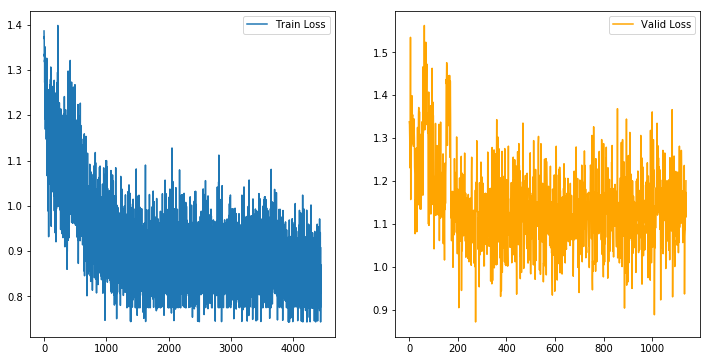

In [84]:
def plot_losses(train_losses, valid_losses)
    tl = np.asarray(train_losses).ravel()
    vl = np.asarray(valid_losses).ravel()
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(tl)
    plt.legend(['Train Loss'])
    plt.subplot(1,2,2)
    plt.plot(vl,'orange')
    plt.legend(['Valid Loss'])

In [231]:
import time
ts = time.gmtime()
stamp = time.strftime("%Y-%m-%d %H:%M:%S", ts)
stamp[:10]

import torch
torch.save(net, 'custom_net_{}_medduration.pth'.format(stamp))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [10]:
from torchvision import transforms, models

In [30]:
alexnet = models.alexnet(pretrained=True)
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [31]:
alexnet.classifier.Linear = nn.Linear(4096, 4, bias=True)
alexnet.features[0] = nn.Conv2d(1, 64, kernel_size=(11,11), stride=(4,4), padding=(2,2))
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [36]:
alexnet.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [37]:
learning_rate = 2e-5
optimizer = optim.Adam(alexnet.parameters(), lr=learning_rate, weight_decay=0.05)
epochs = 20
loss_fn = nn.CrossEntropyLoss()
alexnet_train_losses=[]
alexnet_valid_losses=[]

train_model(alexnet, loss_fn, train_loader, valid_loader, epochs, optimizer, alexnet_train_losses, alexnet_valid_losses, lr_decay)

  0%|          | 0/20 [00:04<?, ?it/s]


RuntimeError: size mismatch, m1: [64 x 1000], m2: [4096 x 4] at /opt/conda/conda-bld/pytorch_1565272269120/work/aten/src/THC/generic/THCTensorMathBlas.cu:273